In [24]:
import lsst.daf.persistence as dafPersist
import matplotlib.pyplot as plt
import numpy as np

import lsst.afw.table as afwTable
import lsst.afw.geom as afwGeom
import Utils.DiaSourceTools as DSTools
from astropy.time import Time

import lsst.afw.display.ds9 as ds9

import re

In [25]:
DATADIR="/datadec/cppm/jpreyes/CFHT_Complete"
directory = DATADIR+"/detect_testSN_2/"
butler = dafPersist.Butler(directory) 
filter = 'r'

In [26]:
patches = []
patches_file=open(DATADIR+"/patches.txt", "rb")
for line in patches_file:
    line = line.replace('\n','')
    text = re.split("=| ",line)
    patches.append(text[-1])
patches_file.close()

dates = []
days_file=open(DATADIR+"/days_06.txt", "rb")

for day in days_file:
    day = day.replace('\n','')
    dates.append(day)

days_file.close()

In [27]:

def get_light_curves_per_patch(butler, filter, dates, patch):

    multi_matches = None
    results = []

    for date in dates:
        t = Time(date)
        date_catalog = None
        #print date
        if butler.datasetExists("dayDiff_class_diaSrc", dataId={"filter":filter,"tract":0, "patch":patch, 'date':date}):
            date_catalog = butler.get("dayDiff_class_diaSrc", dataId={"filter":filter,"tract":0, "patch":patch, 'date':date})
            if multi_matches is None:
                multi_matches= afwTable.MultiMatch(date_catalog.schema, {'mjd':'D'}, radius=afwGeom.Angle(1./3600., afwGeom.degrees))
            multi_matches.add(date_catalog, {'mjd':int(t.mjd)})


    if multi_matches is not None:
        results = multi_matches.finish(removeAmbiguous=False)    
    return results

In [28]:
from multiprocessing import Pool
from functools import partial


In [29]:
p = Pool(50)



partial_lc = partial(get_light_curves_per_patch, butler, filter,dates)

res = p.map(partial_lc, patches)
#f = Pool(25).map(get_light_curves_per_patch, ([butler], ['g'], ['0,20'], [dates]))

In [30]:
lcs = []
for r in res:
    if len(r)>0:
        lcs.extend(DSTools.get_light_curves_from_multimatch_results2(r))
        


In [31]:
len(lcs)

187754

In [32]:
#lcs = DSTools.get_light_curves_from_multimatch_results2(results)
t_lcs = DSTools.threshold_light_curves(lcs, 3)

In [33]:
len(t_lcs)

17616

In [22]:
stack_lc_3 = []
stack_lc_45 = []
stack_lc_6 = []
stack_lc_9 = []

for t_lc in t_lcs:
    stack_lc_3.append(DSTools.build_lightcurve3(t_lc, "base_CircularApertureFlux_3_0_flux"))
    stack_lc_45.append(DSTools.build_lightcurve3(t_lc, "base_CircularApertureFlux_4_5_flux"))
    stack_lc_6.append(DSTools.build_lightcurve3(t_lc, "base_CircularApertureFlux_6_0_flux"))
    stack_lc_9.append(DSTools.build_lightcurve3(t_lc, "base_CircularApertureFlux_9_0_flux"))

06D3bz 214.291841667 53.024825


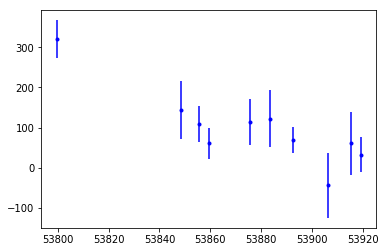

06D3cb 215.181558333 52.1910638889


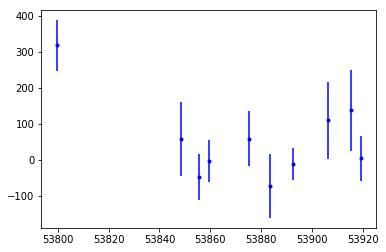

06D3cc 214.381666667 52.9124722222


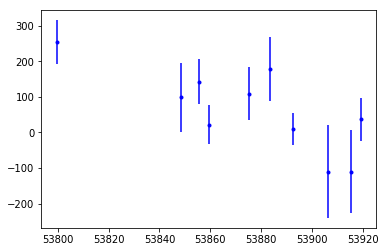

06D3cn 214.8577 52.6409833333


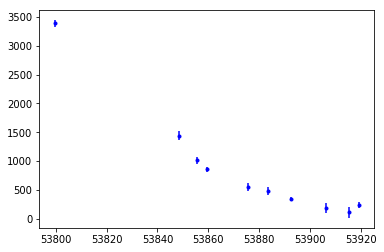

06D3df 215.571704167 52.9576805556


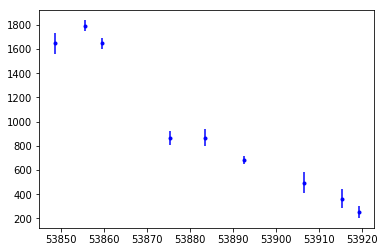

06D3dl 215.552404167 52.6408472222


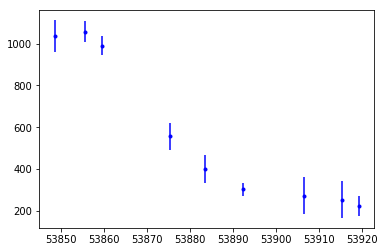

06D3do 214.247466667 52.8825444444


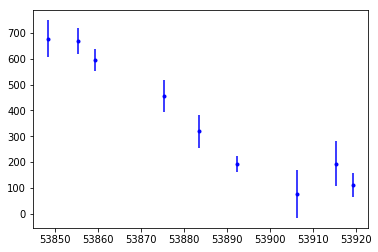

06D3dt 214.340266667 52.4528166667


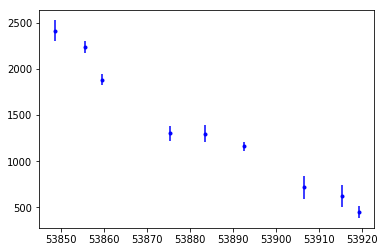

06D3ed 214.699175 52.7565583333


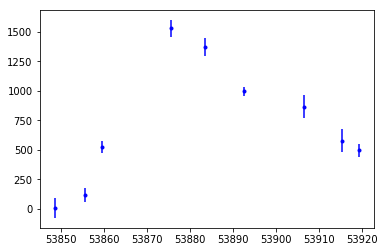

06D3el 214.254529167 52.2324


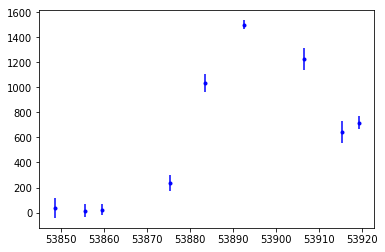

06D3em 214.847579167 53.0230138889


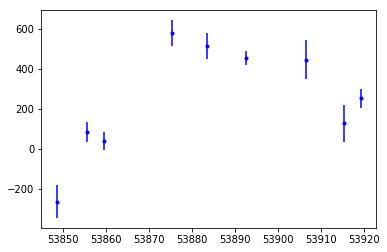

06D3en 215.305566667 52.4560777778


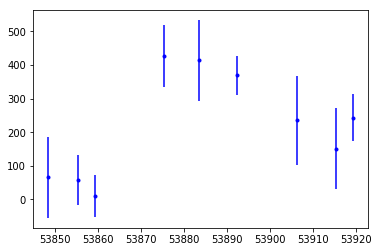

06D3et 215.519875 52.3383666667


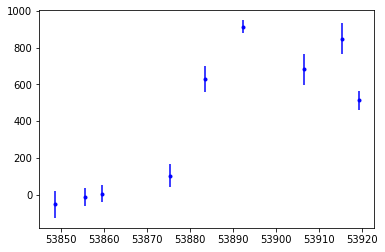

06D3fp 215.077520833 52.8971638889


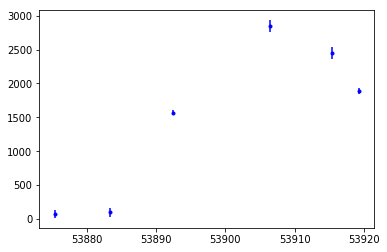

06D3gh 214.6309125 52.4429083333


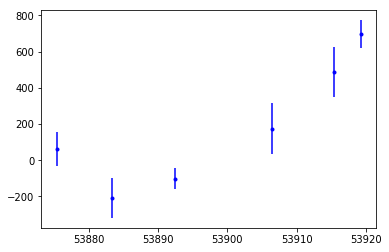

06D3gn 214.435958333 52.3611805556


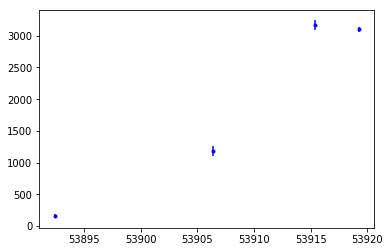

06D3gx 214.263475 52.9362527778


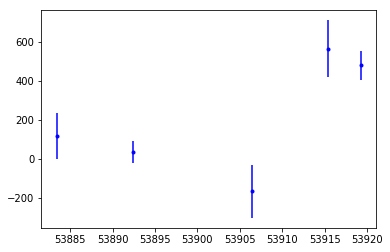

In [15]:
%matplotlib inline
import re
import astropy.coordinates as coord
import astropy.units as u


f = open('/renoir_data_02/jpreyes/lsst_data/sn_control/J_A+A_523_A7_table9.dat.txt','r')
data_elems = f.read()
elems = re.findall('^(06D3.*?)\\|(.*?)\\|', data_elems, re.MULTILINE)

f = open('/renoir_data_02/jpreyes/lsst_data/sn_control/J_A+A_523_A7_table10.dat.txt','r')
data = f.read()

snls_array = []
for sn in elems:
    c = coord.SkyCoord(sn[-1], unit=(u.hourangle, u.deg))
    
    m = re.findall('^'+str(sn[0])+'\\|('+filter+')\\|(.*?)\\|(.*?)\\|(.*?)$', data, re.MULTILINE)

    snls_lc = DSTools.build_light_curve_from_snls_file(m, c)
   
    print sn[0], c.ra.deg, c.dec.deg
    
    plt.errorbar(snls_lc['mjd'], snls_lc['flux'], yerr=snls_lc['flux_error'], fmt='.', color='blue')
    snls_array.append(snls_lc)
    plt.show()

In [16]:
def match_with_lc(snls_array, stack_lc):
    matches = []
    for lc in snls_array:
        #print "light curve"
        val = {"ra":lc[0]["ra"], "dec":lc[0]["dec"]}
        #print np.rad2deg(lc[0]["ra"]), np.rad2deg(lc[0]["dec"])
        for i, slc in enumerate(stack_lc):

            comp = {"ra":np.mean(slc["ra"]), "dec":np.mean(slc["dec"])}
            if DSTools.source_distance(val, comp)<1:
                print i
                matches.append((lc,slc))


    print len(matches)
    return matches

In [17]:
matches_45= match_with_lc(snls_array, stack_lc_45)

7034
1238
12859
11701
11750
12591
8980
1818
11651
9


In [18]:
def show_matches_2(matches):
    factors = []
    for match in matches:
        print len(match[-1])
        print np.rad2deg(match[0][0]['ra']), np.rad2deg(match[0][0]['dec'])
        lc_fluxes = match[0]["flux"]
        factor = max(match[-1]['flux']) / max(lc_fluxes)
        lc_fluxes = np.multiply(lc_fluxes, factor)
        lc_errors = np.multiply(match[0]["flux_error"], factor)
        
        factors.append(factor)
        plt.figure(figsize=(20,10))
        print match[-1]["flux"]
        plt.errorbar(match[-1]["mjd"], match[-1]["flux"],yerr=match[-1]["flux_error"], fmt='.', markersize='5')
        plt.errorbar(match[0]["mjd"], lc_fluxes, yerr=lc_errors, fmt='.', markersize='5')
        plt.show()

4
214.8577 52.6409833333
     flux    
-------------
 51.839717865
 42.805431366
26.3010807037
16.5456829071


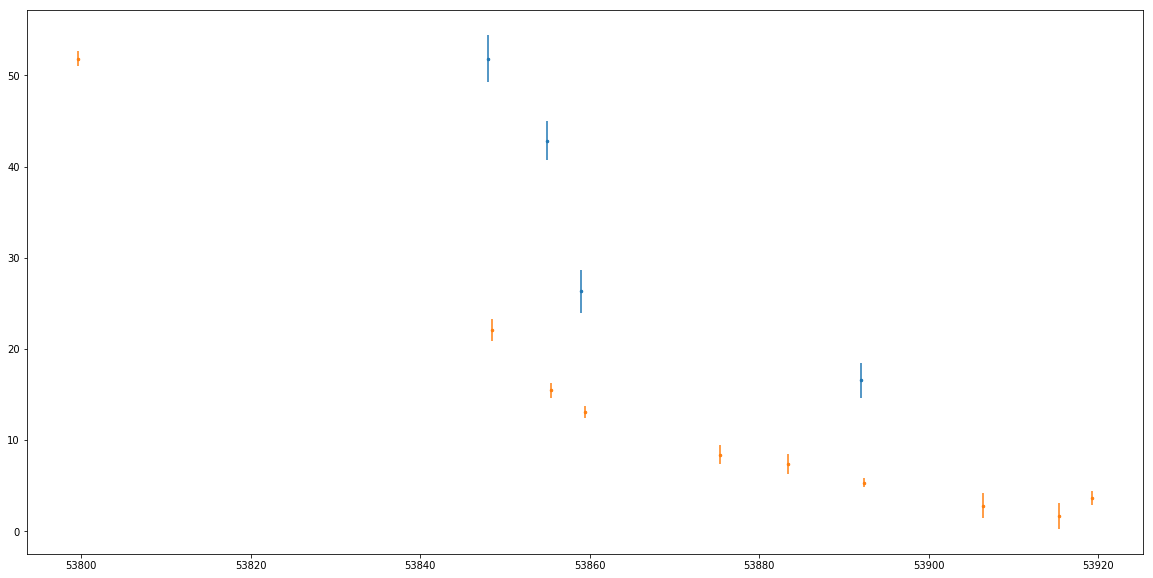

6
215.552404167 52.6408472222
     flux    
-------------
 38.690952301
38.3108825684
19.5299663544
16.6029186249
6.92854118347
11.7923517227


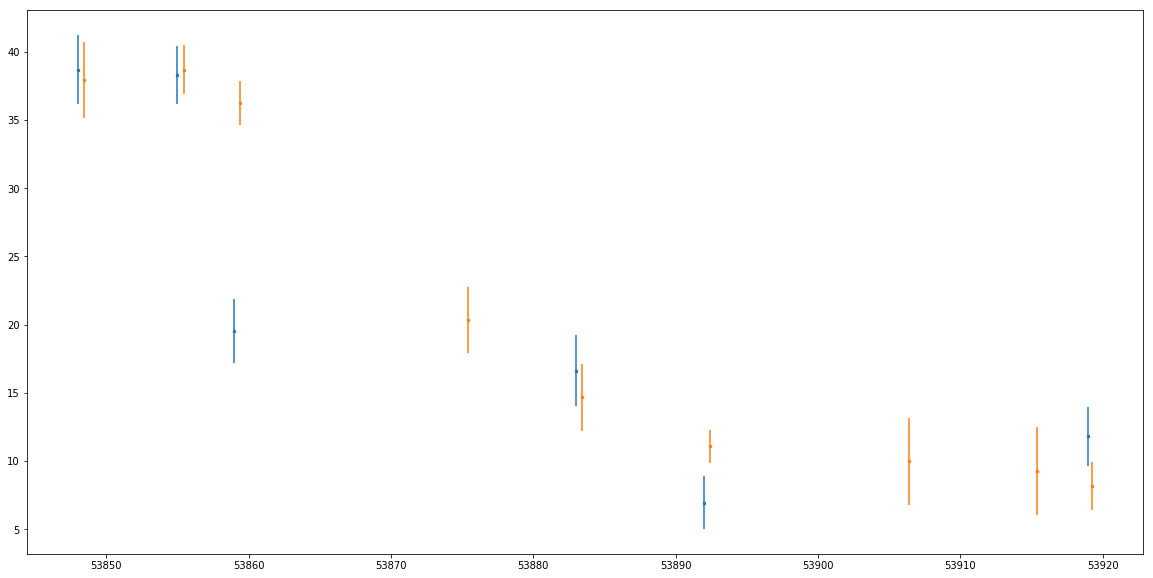

4
214.247466667 52.8825444444
    flux    
------------
         nan
23.712720871
         nan
         nan


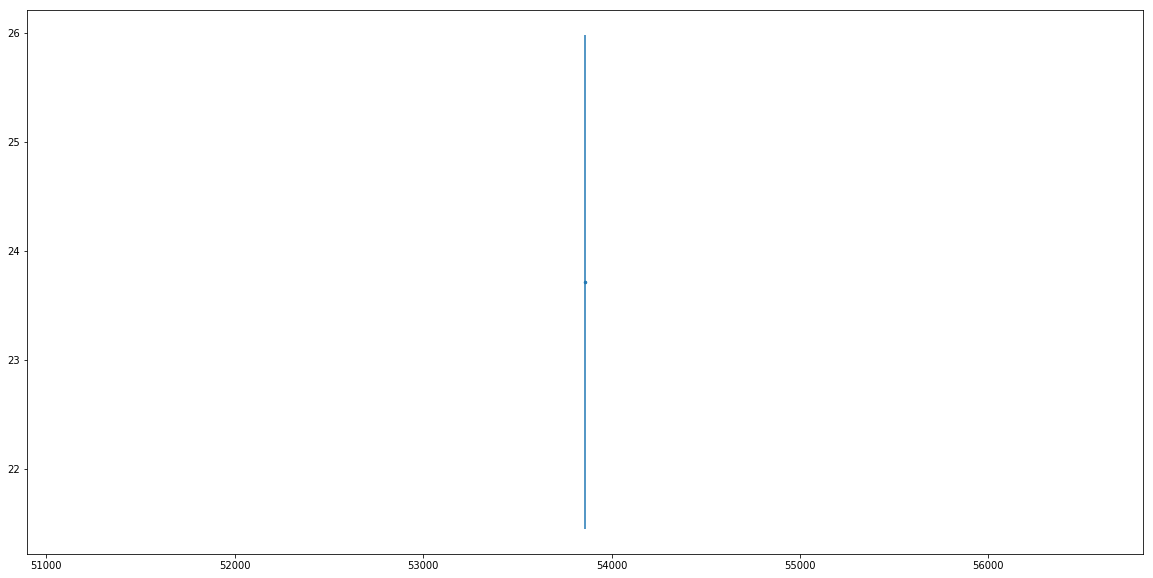

7
214.340266667 52.4528166667
     flux    
-------------
14.5990591049
37.0828094482
30.2931118011
12.8546628952
5.24172210693
27.5139083862
18.1997375488


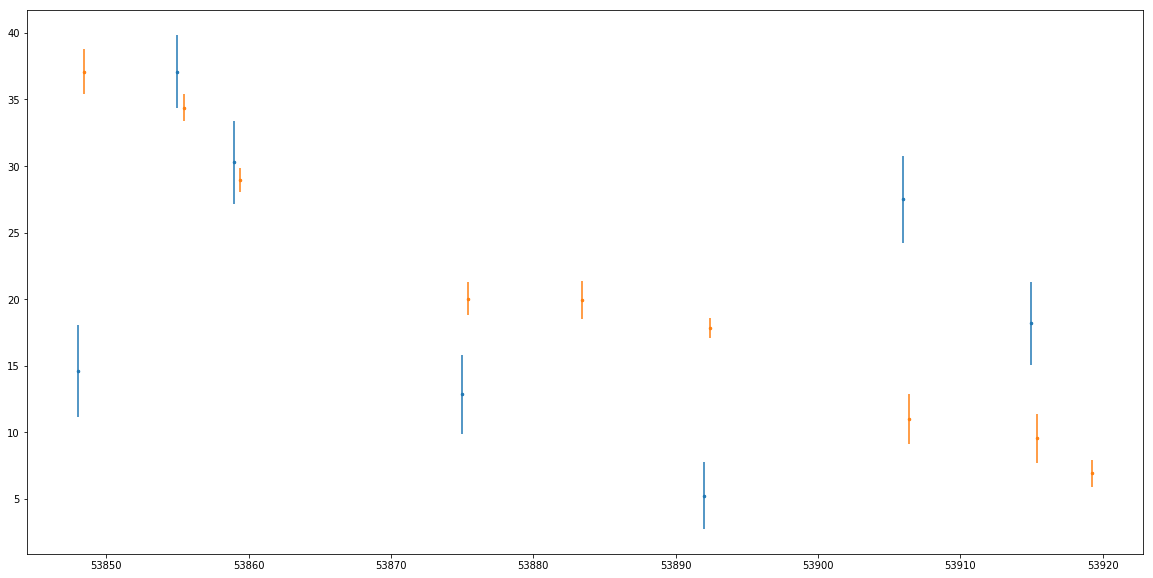

4
214.340266667 52.4528166667
     flux    
-------------
59.6665458679
27.5139083862
18.1997375488
16.5697422028


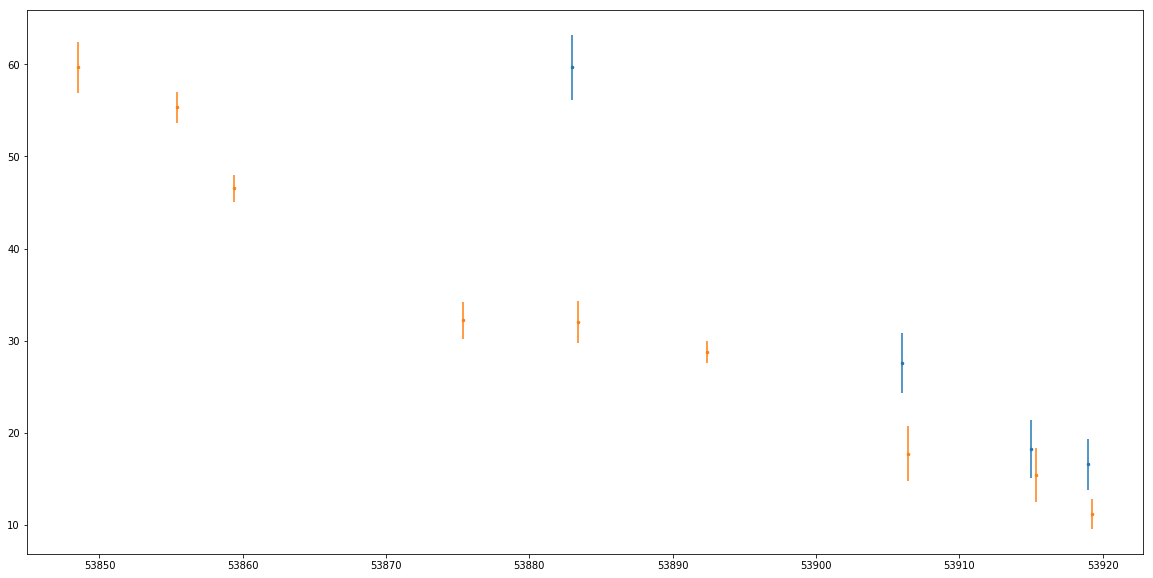

7
214.340266667 52.4528166667
     flux     
--------------
 40.7971839905
 28.3917427063
 10.2125396729
 11.9759550095
-7.36026573181
 24.0722427368
 18.6589450836


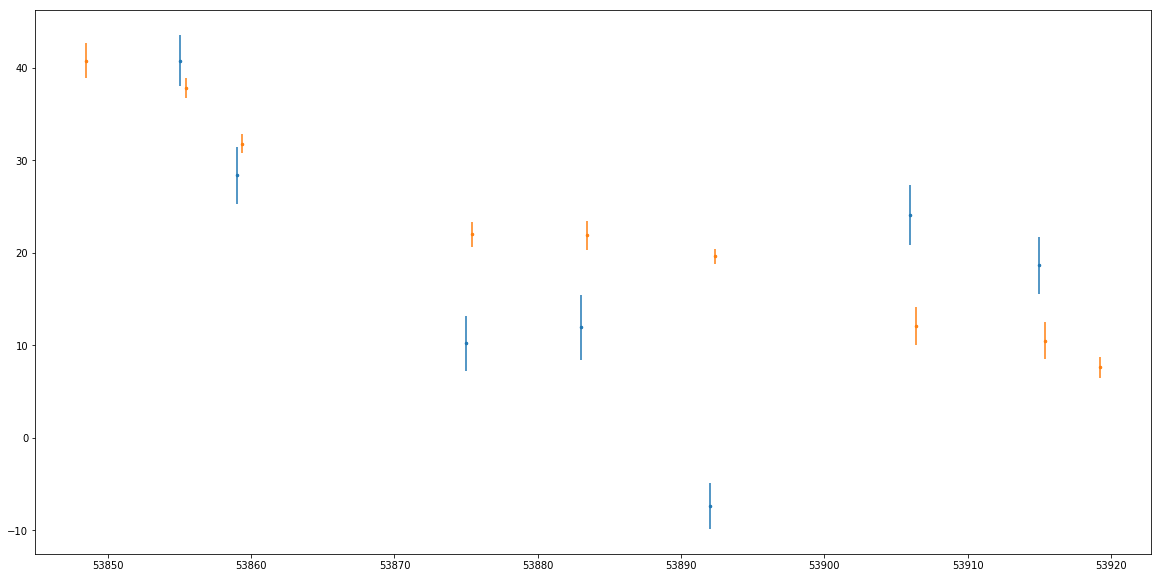

5
214.699175 52.7565583333
     flux    
-------------
 25.327255249
60.0865020752
46.8682746887
29.7374744415
27.5119800568


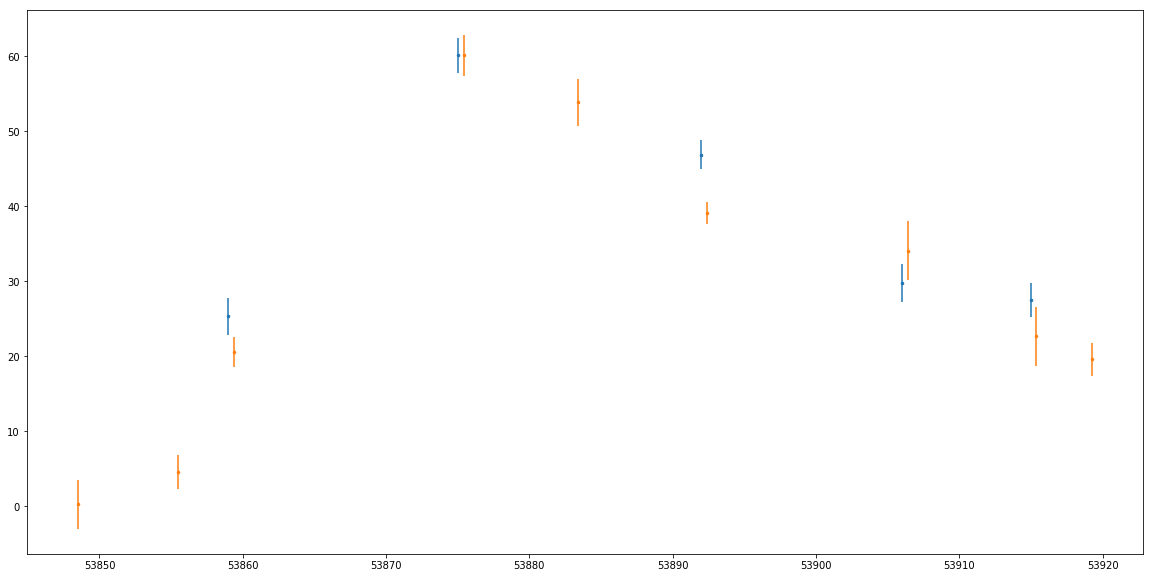

5
215.519875 52.3383666667
     flux     
--------------
-15.1849632263
-4.54324388504
 17.1536426544
 21.4717254639
 23.2590198517


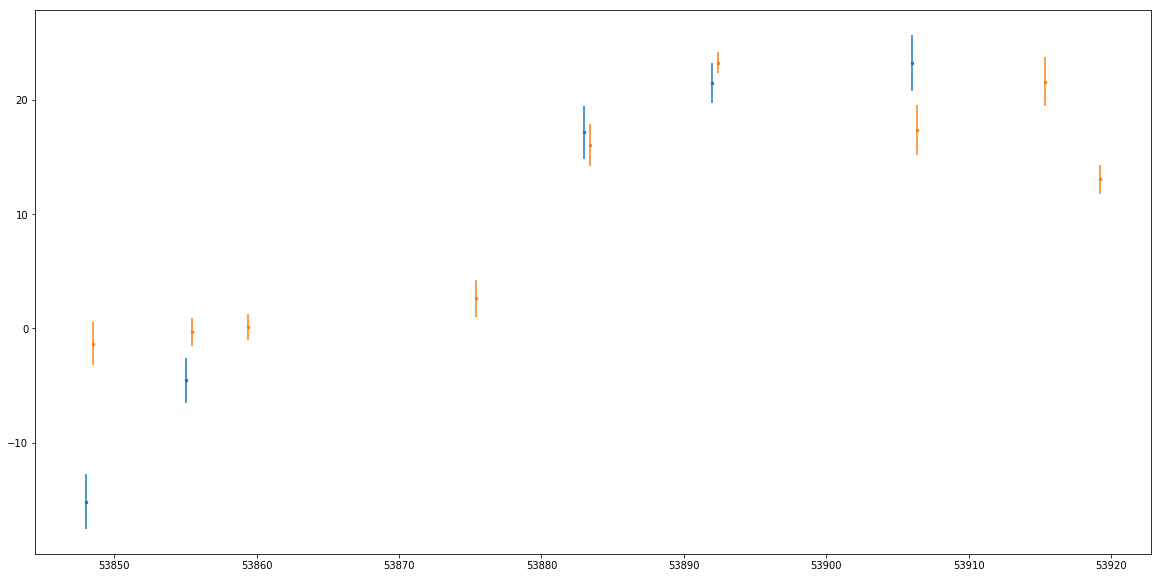

4
214.435958333 52.3611805556
     flux    
-------------
7.19641542435
 42.679473877
52.1162414551
135.029098511


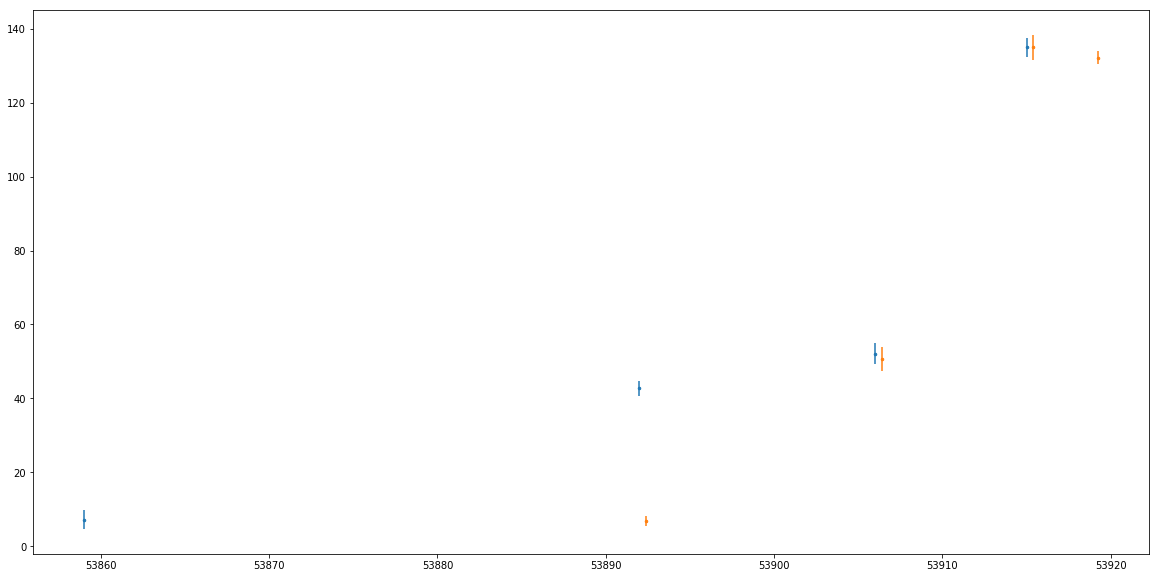

In [19]:
show_matches_2(matches_45)